In [63]:
#импортируем нужные библиотеки
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.stats as st
from tqdm import tqdm
import seaborn as sns

In [60]:
!pip install tqdm

In [3]:
#считаем датасет параллельно переводя даты в общий формат дат timestamp
data_ab = pd.read_csv("ab_data.csv", parse_dates=['timestamp'], dayfirst=False, sep=";")
data_ab.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
data_ab['timestamp'][0].day

21

In [5]:
data_ab['timestamp'][0].year

2017

In [6]:
data_ab['timestamp'][0].month

1

Посмотрим как был выстроен дизайн эксперимента:

Есть две группы (Очевидно): 
    
    1. Контрольная 
    
    2. Тестовая 

У нас есть два сайта со старом дизайном и новым дизайном сайта, здесь мы замеряем метрику - конверсию (дискретную переменную): изменится она или нет от того, что мы поменяли элемент. 

In [7]:
#Посмотрим на распределение контрольной и тестовой группы, а также какая выборка была взята для проведения A/B теста 
print(f"{len(data_ab['group'])} пользователей")
print(data_ab['group'].value_counts())

294478 пользователей
treatment    147276
control      147202
Name: group, dtype: int64


Из-за того, что контрольная и тестовая группа распределены в соотношении 1 к 1 (50 на 50), то не очевидна статистическая значимость при подсчете. Всего пользователей составляет почти 300 тысяч юзеров, которое отобрали для эксперимента.

In [8]:
#Посмотрим сколько длился эксперимент
years = []

for yr in data_ab['timestamp']:
    years.append(yr.year)
    
set(years) #уникальный год только один = 2017

{2017}

In [9]:
data_ab['timestamp'].dt.day.unique()

array([21, 12, 11,  8, 10, 19, 17,  4, 15, 18,  9, 22, 24, 23, 20,  5,  6,
       13,  7,  3,  2, 16, 14], dtype=int64)

In [10]:
len(data_ab['timestamp'].dt.day.unique())

23

In [11]:
#Только один месяц
data_ab['timestamp'].dt.month.unique()

array([1], dtype=int64)

Эксперимент длился 23 дня

In [12]:
#Посмотрим как менялась конверсия в течение 5 дней у каждой из групп
data_ab['Day'] = data_ab['timestamp'].dt.day
data_cr = data_ab[['Day', 'group', 'converted']]
data_cr.head(5)

,Day,group,converted
0,21,control,0
1,12,control,0
2,11,treatment,0
3,8,treatment,0
4,21,control,1


In [13]:
control_data = data_cr.query('group=="control"')
control_data['Day'].unique()

array([21, 12, 10, 17, 22, 24, 23, 13, 11, 16,  8,  5, 18, 20,  3, 19,  7,
       14,  9,  2,  6, 15,  4], dtype=int64)

In [14]:
treatment_data = data_cr.query('group=="treatment"')
treatment_data['Day'].unique()

array([11,  8, 19,  4, 15, 18, 21,  9, 22, 12, 23, 20,  5,  6,  7,  3,  2,
       17, 13, 14, 10, 16, 24], dtype=int64)

In [15]:
days_sr = control_data['Day'].unique()
days = []

for day in days_sr:
    days.append(day)
    
days.sort()

In [16]:
days_sr = treatment_data['Day'].unique()
days_test = []

for day in days_sr:
    days_test.append(day)
    
days_test.sort()

In [17]:
days[:5]

[2, 3, 4, 5, 6]

In [18]:
conversion_data = {}
conversion = []

for day in days:
    conversion_data[day] = control_data.query(f'Day=={day}')['converted'].sum() / len(control_data.query(f'Day=={day}')['converted'])
    conversion.append(control_data.query(f'Day=={day}')['converted'].sum() / len(control_data.query(f'Day=={day}')['converted']))

In [19]:
conversion[:5]

[0.12508638562543192,
 0.11370436864153202,
 0.1217129977460556,
 0.12251453043744265,
 0.11639736684619988]

In [20]:
conversion_data = {}
conversion_test = []

for day in days:
    conversion_data[day] = treatment_data.query(f'Day=={day}')['converted'].sum() / len(treatment_data.query(f'Day=={day}')['converted'])
    conversion_test.append(treatment_data.query(f'Day=={day}')['converted'].sum() / len(treatment_data.query(f'Day=={day}')['converted']))

In [21]:
conversion_test[:5]

[0.12045690550363447,
 0.1135618479880775,
 0.11660883994569317,
 0.11509262071059824,
 0.12390414962010521]

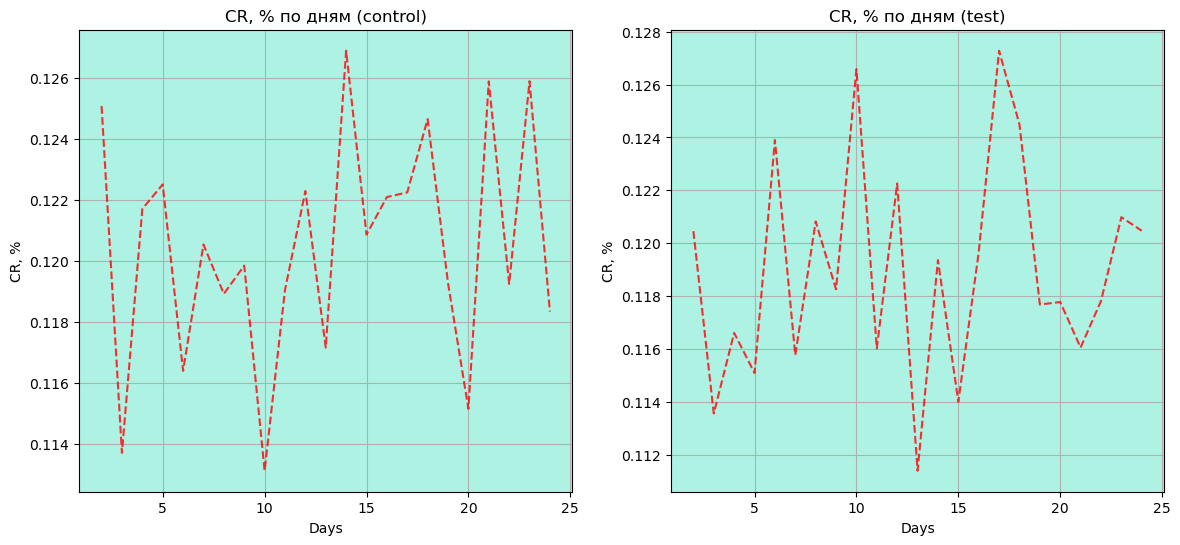

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(days, conversion, ls="--", color="red", alpha=0.8)
axes[0].set_title("CR, % по дням (control)")
axes[0].set_ylabel("CR, %")
axes[0].set_xlabel("Days")
axes[0].set_facecolor("#aef2e4")
axes[0].grid()

axes[1].plot(days_test, conversion_test, ls="--", color="red", alpha=0.8)
axes[1].set_title("CR, % по дням (test)")
axes[1].set_ylabel("CR, %")
axes[1].set_xlabel("Days")
axes[1].set_facecolor("#aef2e4")
axes[1].grid()

По графику видно, что конверсия по контрольной группе равняется примено 12%, а по тестовой немного выше

Теперь посчитаем общую конверсию и сформулируем нулевую и альтернативную гипотезы для проверки бутстрепом

In [23]:
data_cr.groupby(['group']).agg({'converted':'mean'})

,converted
group,
control,0.120399
treatment,0.118920


Видим, что общая конверсия уменьшилась после изменений дизайна сайта/приложения.

Для начала давайте посчитаем доверительные интервалы для конверсий двух групп. 

In [24]:
data_cntrl = data_ab[['landing_page', 'group', 'converted']].query("group=='control'")
data_cntrl

,landing_page,group,converted
0,old_page,control,0
1,old_page,control,0
4,old_page,control,1
5,old_page,control,0
7,old_page,control,0
...,...,...,...
294471,old_page,control,0
294473,old_page,control,0
294474,old_page,control,0
294475,old_page,control,0


In [25]:
n = sum(data_cntrl['converted'])
p = n / len(data_cntrl['converted'])

n, p

(17723, 0.12039917935897611)

In [26]:
error = 0.02
se = np.sqrt(p * (1 - p) / n)
#Доверительный интервал для контрольной группы
di_control = st.norm.interval(0.95, loc=p, scale=se)
di_control

(0.11560809245335793, 0.12519026626459429)

In [27]:
data_test = data_ab[['landing_page', 'group', 'converted']].query("group=='treatment'")
data_test

,landing_page,group,converted
2,new_page,treatment,0
3,new_page,treatment,0
6,new_page,treatment,1
8,new_page,treatment,1
9,new_page,treatment,1
...,...,...,...
294462,new_page,treatment,0
294465,new_page,treatment,0
294468,new_page,treatment,0
294472,new_page,treatment,0


In [28]:
n = sum(data_test['converted'])
p = n / len(data_test['converted'])

n, p

(17514, 0.11891957956489856)

In [29]:
error = 0.02
se = np.sqrt(p * (1 - p) / n)
#Доверительный интервал для тестовой группы
di_test = st.norm.interval(0.95, loc=p, scale=se)
di_test

(0.11412566956865315, 0.12371348956114396)

In [30]:
di_control

(0.11560809245335793, 0.12519026626459429)

In [31]:
di_test

(0.11412566956865315, 0.12371348956114396)

Доверительные интервалы пересекаются => разница есть

Проверим бутстрепом

H0: Полученная конверсия на новом сайте не отличается от конверсии на старом сайте

H1: Полученная конверсия на старом сайте ниже полученной конверсии на новом сайте

In [32]:
data_cr.groupby(['group']).agg({'converted':'mean'})

,converted
group,
control,0.120399
treatment,0.118920


In [52]:
A_btsr = (data_ab.query(" group == 'control' ")['converted'])
B_btsr = (data_ab.query(" group == 'treatment' ")['converted'])
A_btsr

0         0
1         0
4         1
5         0
7         0
         ..
294471    0
294473    0
294474    0
294475    0
294476    0
Name: converted, Length: 147202, dtype: int64

In [38]:
A_ = 0.120399
B_ = 0.118920
AB_diff = A_ -  B_ #разница в конверсиях 
AB_diff 

0.001479000000000008

In [64]:
N = 2000 #количество семплов
result = [] 

for _ in tqdm(range(N)):
    a = A_btsr.sample(n= len(A_btsr), replace=True)
    b = B_btsr.sample(n= len(B_btsr), replace=True)
    p1 = sum(a)/len(a)
    p2 = sum(b)/len(b)
    p_diff = p2 - p1
    result.append(p_diff)

100%|██████████| 2000/2000 [03:06<00:00, 10.72it/s]


In [66]:
result[:5]

[-0.001716968935920063,
 -0.0013172309690622774,
 -0.0052420194367711614,
 -0.0008822938382855722,
 -0.001642180249329786]

<Axes: ylabel='Count'>

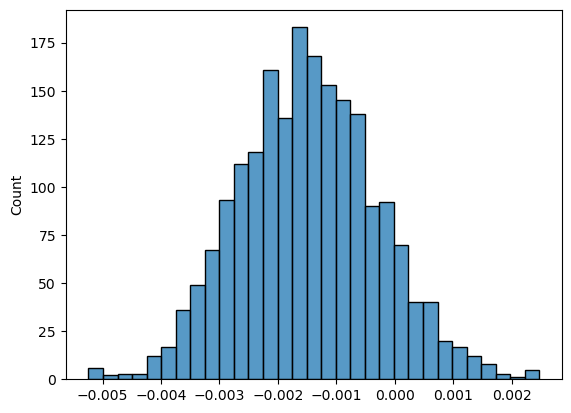

In [72]:
#Посмотрим на распределение
sns.histplot(result)

In [86]:
result_more = []
base_diff = 0.001479000000000008

for item in result: 
    if item > base_diff:
        result_more.append(item)

In [88]:
p_value = sum(result_more) / N
p_value

1.6138908403244777e-05

p_value - стремится к нулю, поэтому при уровне значимости в 5% мы можем отвергнуть нулевую гипотезу и принять альтернативную, что разница в конверсиях все-таки есть